# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. 

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
data = pd.read_csv('Churn.csv')

data.columns = list(data.columns.str.lower()) # колонки в нижний регистр 
data = data.drop(['surname', 'rownumber', 'customerid'], axis=1) # Дропаю фамилии тк не дает информации для модели 
data['tenure'] = data['tenure'].fillna(data['tenure'].median()) # Заполнил пропуски в колонке недвижимость медианой


data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалил  столбцы с фамилиями, rownumber, customerid, тк нужной информации они нам не дают.<br>
так же пропущеные значения в столбце с недвижимостью заполнин медианой.

<AxesSubplot:>

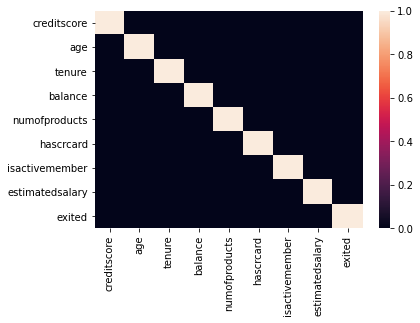

In [5]:
sns.heatmap(data.corr() > 0.8)

Мультиколлинеарности не обнаружил

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Использовал кодирование OHE к датафрейму. C параметром drop_first=True, для того чтобы не угодить в ловушку фиктивных признаков.

### Вывод.
Разделил данные на 3 выборки тренировочную, валидационую, тестовую. В отношении 3:1:1.

# 3. Борьба с дисбалансом

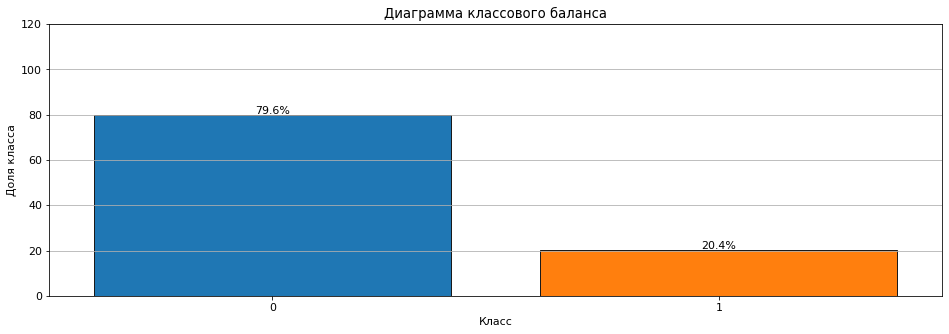

In [9]:
def class_bar(data, sign):
    df = data.copy()
    df_row = (df[sign].value_counts(normalize = True) * 100).reset_index()
    
    plt.gcf().set_size_inches(16, 5)
    plt.rcParams.update({'font.size': 11})
    sns.barplot(x = 'index', y = sign, data = df_row, edgecolor='.1', saturation = 1)
    for index, row_text in df_row.iterrows():
            plt.text(index, row_text[sign] * 1.01, '{}%'.format(round(row_text[sign], 1)), color = 'black', ha = 'center')
        
    plt.ylim([0, 120])
    plt.grid(axis = 'y')
    plt.xlabel('Класс')
    plt.ylabel('Доля класса')
    plt.title('Диаграмма классового баланса')

class_bar(data, 'exited')

Наблюдается дисбаланс классов применим метод upsample.

In [10]:
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
            features_upsampled, target_upsampled, random_state=666)
    
    return features_upsampled, target_upsampled

In [32]:
def make_features(features, target):
    features = features
    target =  target

    features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.25, random_state=666, stratify=target)
    
    features_train, target_train = upsample(features_train, target_train, 3)
    
    
    return features_train, features_test, target_train, target_test

Увеличим обучающую выборку в 3 раза.

In [33]:
target = data_ohe['exited']
features = data_ohe.drop(['exited'], axis=1)

features_train, features_test, target_train, target_test = make_features(features, target)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(10556, 11) (10556,)
(2500, 11) (2500,)


In [35]:
target_train.value_counts()

0    5972
1    4584
Name: exited, dtype: int64

Сбалансировали классы в обучающей выборке.

## Обучение моделей.

In [60]:
f1 = make_scorer(f1_score)

def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score,
                   'precision' : precision_score,
                   'recall' : recall_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5, param_grid=params, n_jobs=-1, scoring=f1)
            grid.fit(features_train, target_train)
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [62]:
models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
          
          'Forest' : [RandomForestClassifier(random_state=666, n_jobs=-1), {'max_depth':range(1, 12, 3),
                                                                            'min_samples_leaf':range(1,12, 3),
                                                                            'min_samples_split':range (2, 13,3)}],
          
          'Tree': [DecisionTreeClassifier(random_state=666), {'max_depth':range(1, 15, 2),
                                                              'min_samples_leaf':range(1 ,20, 3),
                                                              'min_samples_split':range (2, 20,3)}],
          
          'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                     'max_depth':range(1, 25, 3),
                                                                     'n_estimators':range(1, 451, 35)}],
          
          'CatBoost' : [CatBoostClassifier(random_state=666, silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 15, 3)}]
         }

__________Linear__________
                  train      test
f1             0.643108  0.491512
accuracy       0.711065  0.748400
roc auc score  0.698097  0.692146
precision      0.693589  0.417582
recall         0.599476  0.597250

__________Forest__________
                  train      test
f1             0.867478  0.607862
accuracy       0.889636  0.836400
roc auc score  0.882916  0.756900
precision      0.906347  0.593633
recall         0.831806  0.622790

__________Tree__________
                  train      test
f1             0.929614  0.524680
accuracy       0.937855  0.792000
roc auc score  0.938689  0.707089
precision      0.914696  0.490598
recall         0.945026  0.563851

__________LightGBM__________
                  train      test
f1             0.995545  0.581665
accuracy       0.996116  0.841200
roc auc score  0.996491  0.729935
precision      0.991773  0.627273
recall         0.999346  0.542240

__________CatBoost__________
                  train      test
f1       

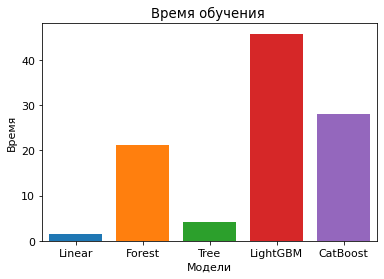

Wall time: 1min 40s


In [63]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

### Вывод.
Выбираем модель RandomForest.
1. Высокое значение f1 метрики.
2. Высокая скорость обучения.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59